In [2]:
# Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os        
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.preprocessing import LabelEncoder
import string
import subprocess
from sklearn.preprocessing import MaxAbsScaler
from sklearn.pipeline import make_pipeline
from gensim.models import Word2Vec
import gensim.downloader as api
import joblib
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score, classification_report
from transformers import get_linear_schedule_with_warmup

import xgboost as xgb

In [3]:
df = pd.read_csv('converse.csv')
df.head()

,conversation_id,message,sentiment
0,1.0,Are you a fan of Google or Microsoft?,Curious to dive deeper
1,1.0,Both are excellent technology they are helpfu...,Curious to dive deeper
2,1.0,"I'm not a huge fan of Google, but I use it a...",Curious to dive deeper
3,1.0,Google provides online related services and p...,Curious to dive deeper
4,1.0,"Yeah, their services are good. I'm just not a...",Curious to dive deeper


In [4]:
df = df.drop("conversation_id", axis=1)

In [5]:
df

,message,sentiment
0,Are you a fan of Google or Microsoft?,Curious to dive deeper
1,Both are excellent technology they are helpfu...,Curious to dive deeper
2,"I'm not a huge fan of Google, but I use it a...",Curious to dive deeper
3,Google provides online related services and p...,Curious to dive deeper
4,"Yeah, their services are good. I'm just not a...",Curious to dive deeper
...,...,...
194310,i begun to feel distressed for you,fear
194311,i left feeling annoyed and angry thinking that...,anger
194312,i were to ever get married i d have everything...,joy
194313,i feel reluctant in applying there because i w...,fear


In [6]:
variations = df['sentiment'].value_counts()
print(variations)

 Curious to dive deeper    80888
 Neutral                   41367
 Surprised                 30638
 Happy                     29617
 Sad                        2533
anger                       2000
joy                         2000
fear                        1937
 Disgusted                  1433
 Fearful                    1026
 Angry                       876
Name: sentiment, dtype: int64


In [7]:
# Pre-processing of the sentiment column
df['sentiment'] = df['sentiment'].str.strip()

In [8]:
df['sentiment'].value_counts()

Curious to dive deeper    80888
Neutral                   41367
Surprised                 30638
Happy                     29617
Sad                        2533
anger                      2000
joy                        2000
fear                       1937
Disgusted                  1433
Fearful                    1026
Angry                       876
Name: sentiment, dtype: int64

In [9]:
# Creating similarity
sentiment_mapping = {
    'Curious to dive deeper': 'Interested',
    'Neutral': 'Neutral',
    'Surprised': 'Surprised',
    'Happy': 'Happy',
    'Sad': 'Sad',
    'anger': 'Angry',
    'joy': 'Happy',
    'fear': 'Fear',
    'Fear': 'Fear',
    'Disgusted': 'Disgusted',
    'Fearful': 'Fear',
    'Angry': 'Angry'
}

In [10]:
df['sentiment_grouped'] = df['sentiment'].map(sentiment_mapping)

In [11]:
df.tail(200)

,message,sentiment,sentiment_grouped
194115,i did feel complacent that now in britain with...,joy,Happy
194116,i will feel so glad to go sing me to sleep sin...,joy,Happy
194117,i feel like thats what vicious circle is,anger,Angry
194118,i keep feel irritated,anger,Angry
194119,i travel i feel like men expect me to be neuro...,fear,Fear
...,...,...,...
194310,i begun to feel distressed for you,fear,Fear
194311,i left feeling annoyed and angry thinking that...,anger,Angry
194312,i were to ever get married i d have everything...,joy,Happy
194313,i feel reluctant in applying there because i w...,fear,Fear


In [12]:
sentiment_counts_grouped = df['sentiment_grouped'].value_counts()
print(sentiment_counts_grouped)

Interested    80888
Neutral       41367
Happy         31617
Surprised     30638
Fear           2963
Angry          2876
Sad            2533
Disgusted      1433
Name: sentiment_grouped, dtype: int64


4    80888  
5    41367  
3    31617  
7    30638  
2     2963  
0     2876  
6     2533  
1     1433  

In [13]:
df.isnull().sum()

message              0
sentiment            0
sentiment_grouped    0
dtype: int64

<Axes: xlabel='sentiment_grouped', ylabel='count'>

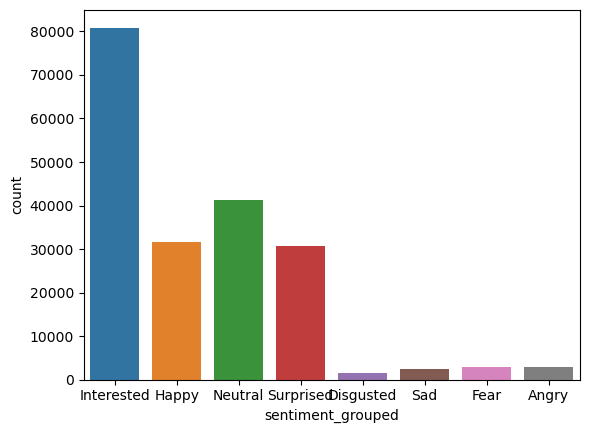

In [14]:
sns.countplot(x = df['sentiment_grouped'])

In [15]:
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\GOTTG\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [16]:
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\GOTTG\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\GOTTG\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [17]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [18]:
stop_words = set(stopwords.words('english'))

In [19]:
def preprocess_text(text):
    # Tokenizing the text
    tokens = word_tokenize(text)
    
    # Removing stop words
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Stemming
    tokens = [stemmer.stem(word) for word in tokens]

    # Joining the tokens back into a sentence
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

# Applying the preprocessing function to the 'Comment' column
df['processed_message'] = df['message'].apply(preprocess_text)

# Displaying the preprocessed DataFrame
df.head()

,message,sentiment,sentiment_grouped,processed_message
0,Are you a fan of Google or Microsoft?,Curious to dive deeper,Interested,are fan googl microsoft ?
1,Both are excellent technology they are helpfu...,Curious to dive deeper,Interested,both excel technolog help mani way . for secur...
2,"I'm not a huge fan of Google, but I use it a...",Curious to dive deeper,Interested,"i 'm huge fan googl , i use lot i . i think mo..."
3,Google provides online related services and p...,Curious to dive deeper,Interested,"googl provid onlin relat servic product , incl..."
4,"Yeah, their services are good. I'm just not a...",Curious to dive deeper,Interested,"yeah , servic good . i 'm fan intrus person li..."


In [20]:
# Initializing the LabelEncoder
label_encoder = LabelEncoder()

# Encoding the 'sentiment_grouped' column into numerical values
df['sentiment_label'] = label_encoder.fit_transform(df['sentiment_grouped'])

# Displaying the first 5 rows of the DataFrame
print(df.head(5))


                                             message               sentiment  \
0              Are you a fan of Google or Microsoft?  Curious to dive deeper   
1   Both are excellent technology they are helpfu...  Curious to dive deeper   
2   I'm not  a huge fan of Google, but I use it a...  Curious to dive deeper   
3   Google provides online related services and p...  Curious to dive deeper   
4   Yeah, their services are good. I'm just not a...  Curious to dive deeper   

  sentiment_grouped                                  processed_message  \
0        Interested                          are fan googl microsoft ?   
1        Interested  both excel technolog help mani way . for secur...   
2        Interested  i 'm huge fan googl , i use lot i . i think mo...   
3        Interested  googl provid onlin relat servic product , incl...   
4        Interested  yeah , servic good . i 'm fan intrus person li...   

   sentiment_label  
0                4  
1                4  
2          

In [21]:
df['sentiment_label'].value_counts()

4    80888
5    41367
3    31617
7    30638
2     2963
0     2876
6     2533
1     1433
Name: sentiment_label, dtype: int64

In [22]:
# Splitting the data into features (X) and target variable (y)
X = df['processed_message']
y = df['sentiment_label']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# Initializing the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Transforming the training and testing data
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [24]:
X_train_tokens = [text.split() for text in X_train]
X_test_tokens = [text.split() for text in X_test]

word2vec_model = Word2Vec(sentences=X_train_tokens, vector_size=100, window=5, min_count=1, workers=4)

def document_to_mean_vector(document, model, vector_size=100):
    vectors = [model.wv[word] for word in document if word in model.wv]

    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(vector_size)

# Converting each document in the train and test sets to mean vector
X_train_word2vec = [document_to_mean_vector(doc, word2vec_model) for doc in X_train_tokens]
X_test_word2vec = [document_to_mean_vector(doc, word2vec_model) for doc in X_test_tokens]

# Stacking the vectors to create a 2D array
X_train_word2vec = np.vstack(X_train_word2vec)
X_test_word2vec = np.vstack(X_test_word2vec)

# Replacing NaNs and infinite values, if any
X_train_word2vec = np.nan_to_num(X_train_word2vec)
X_test_word2vec = np.nan_to_num(X_test_word2vec)
joblib.dump(word2vec_model, 'word2vec_model.pkl')

['word2vec_model.pkl']

In [25]:
# Initializing the Naive Bayes classifier
naive_bayes = MultinomialNB()

# Training the classifier on the training data
naive_bayes.fit(X_train_tfidf, y_train)

# Making predictions on the test data
y_pred = naive_bayes.predict(X_test_tfidf)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Classification Report
print('\nClassification Report:\n', classification_report(y_test, y_pred))


Accuracy: 0.45

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.11      0.19       599
           1       0.00      0.00      0.00       274
           2       0.86      0.11      0.20       554
           3       0.50      0.11      0.17      6373
           4       0.45      0.96      0.61     16236
           5       0.45      0.10      0.16      8219
           6       0.00      0.00      0.00       516
           7       0.41      0.03      0.06      6092

    accuracy                           0.45     38863
   macro avg       0.45      0.18      0.17     38863
weighted avg       0.45      0.45      0.33     38863



C:\Users\GOTTG\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\GOTTG\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\GOTTG\AppData\Local\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
logreg = make_pipeline(MaxAbsScaler(), LogisticRegression(max_iter=1000))
logreg.fit(X_train_tfidf, y_train)
y_pred_logreg = logreg.predict(X_test_tfidf)
joblib.dump(logreg, 'logreg_model.pkl')

# Evaluating the models

print(f'Accuracy: {accuracy_score(y_test, y_pred_logreg):.2f}')
print('Classification Report:\n', classification_report(y_test, y_pred_logreg))

Accuracy: 0.49
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.57      0.69       599
           1       0.30      0.01      0.02       274
           2       0.78      0.56      0.65       554
           3       0.43      0.25      0.31      6373
           4       0.53      0.76      0.62     16236
           5       0.41      0.34      0.37      8219
           6       0.44      0.11      0.18       516
           7       0.40      0.28      0.33      6092

    accuracy                           0.49     38863
   macro avg       0.52      0.36      0.40     38863
weighted avg       0.47      0.49      0.46     38863



In [ ]:
def predict_sentiment(text):
    preprocessed_text = preprocess_text(text)
    text_vector = document_to_mean_vector(preprocessed_text, word2vec_model)
   # text_vector = text_vector.reshape(1, -1)  
    prediction = logreg.predict(text_vector)
    return prediction[0]

In [ ]:
input_text = input("i feel to write something is making me reluctant")
predicted_class = predict_sentiment(input_text)
print(f"The predicted sentiment class is: {predicted_class}")

In [ ]:

xgb_classifier = xgb.XGBClassifier(objective="multi:softmax", num_class=len(df['sentiment_grouped'].unique()), random_state=42)
xgb_classifier.fit(X_train_tfidf, y_train)
y_pred_xgb = xgb_classifier.predict(X_test_tfidf)


print(f'Accuracy: {accuracy_score(y_test, y_pred_xgb):.2f}')
print('Classification Report:\n', classification_report(y_test, y_pred_xgb))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred_xgb))

In [ ]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_tfidf, y_train)
y_pred_rf = rf_classifier.predict(X_test_tfidf)



print(f'Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}')
print('Classification Report:\n', classification_report(y_test, y_pred_rf))


